In [1]:
import json

batch_file = '../data/json/cedar_batch_total_dedicated_nt.json'
pilots8_file = '../data/json/cedar_pilots8_total_dedicated_nt.json'
pilots16_file = '../data/json/cedar_pilots16_total_dedicated_nt.json'

def load_json(fn):
    with open(fn, 'r') as f:
        return json.load(f)

batch = load_json(batch_file)
pilots8 = load_json(pilots8_file)
pilots16 = load_json(pilots16_file)

In [2]:
#get makespans
assert(len(batch)==len(pilots8)==len(pilots16))

def makespan_dict():
    return { 'batch': [], '8pilots': [], '16pilots': [] }
def all_succeeded(i):
    return batch[i]['success'] and pilots8[i]['success'] and pilots16[i]['success']

dedicated_1 = makespan_dict()
dedicated_2 = makespan_dict()
dedicated_3 = makespan_dict()

get_makespan = lambda x: x['end_time'] - x['start_time'] if x['success'] else 0
is_same = lambda x, i: x in pilots8[i]['name'] and x in pilots16[i]['name']
current_dict = None
for i in range(len(batch)):
    if 'single' in batch[i]['name']:
        assert(is_same('1d', i))
        current_dict = dedicated_1
        if not all_succeeded(i):
            print('some 1d failed')
    elif 'double' in batch[i]['name']:
        assert(is_same('2d', i))
        current_dict = dedicated_2
        if all_succeeded(i):
            print('some 2d failed')
    elif 'triple' in batch[i]['name']:
        assert(is_same('3d', i))
        current_dict = dedicated_3
        if not all_succeeded(i):
            print('some 3d failed')
    current_dict['batch'].append(get_makespan(batch[i]))
    current_dict['8pilots'].append(get_makespan(pilots8[i]))
    current_dict['16pilots'].append(get_makespan(pilots16[i]))
        

some 2d failed
some 1d failed
some 2d failed
some 2d failed
some 3d failed
some 1d failed
some 2d failed
some 1d failed
some 1d failed
some 3d failed


In [3]:
from statistics import mean

def get_mean(x):
    values = [i for i in x if i != 0]
    if len(values) > 0:
        return mean(values)
    return 0

get_all_means = lambda i: (get_mean(dedicated_1[i]), get_mean(dedicated_2[i]), get_mean(dedicated_3[i]))
batch_mean = get_all_means('batch')
pilots8_mean = get_all_means('8pilots')
pilots16_mean = get_all_means('16pilots')
print(batch_mean, pilots8_mean, pilots16_mean)

(5676.196373033524, 4582.464561843872, 4697.043655920029) (8113.164766788483, 5972.916296839714, 4721.109323322773) (6085.4590943654375, 4467.310460627079, 4793.1063396930695)


In [4]:
from matplotlib import pyplot as plt
import numpy as np

n_groups = 3

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.30

opacity = 0.4

rects1 = ax.bar(index, batch_mean, bar_width,
                alpha=opacity, color='r',
                label='batch')

rects2 = ax.bar(index + bar_width, pilots8_mean, bar_width,
                alpha=opacity, color='b',
                label='8 pilots')

rects3 = ax.bar(index + 2*bar_width, pilots16_mean, bar_width,
                alpha=opacity, color='green',
                label='16 pilots')

ax.set_xlabel('# dedicated nodes')
ax.set_ylabel('mean makespan (s)')
ax.set_title('Beluga')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels((1, 2, 3))
ax.legend()

plt.show()

<Figure size 640x480 with 1 Axes>

## FIGURE 0 - RAW

In [5]:
## individual bar charts

def individual_charts(data, n_dedicated):
    n_groups = len(data['batch'])

    fig, ax = plt.subplots()

    index = np.arange(n_groups)
    bar_width = 0.30

    opacity = 0.4

    rects1 = ax.bar(index, data['batch'], bar_width,
                    alpha=opacity, color='r',
                    label='batch')

    rects2 = ax.bar(index + bar_width, data['8pilots'], bar_width,
                    alpha=opacity, color='b',
                    label='8 pilots')

    rects3 = ax.bar(index + 2*bar_width, data['16pilots'], bar_width,
                    alpha=opacity, color='green',
                    label='16 pilots')

    ax.set_xlabel('Iteration #')
    ax.set_ylabel('makespan (s)')
    ax.set_title('Beluga - {} dedicated'.format(n_dedicated))
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels((i + 1 for i in range(n_groups)))
    ax.legend()

    plt.show()

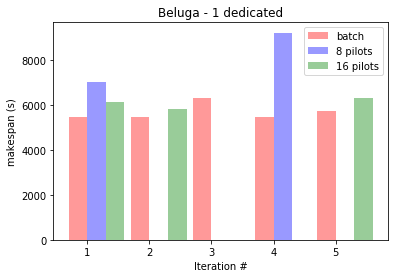

In [6]:
## 1 dedicated
individual_charts(dedicated_1, 1)

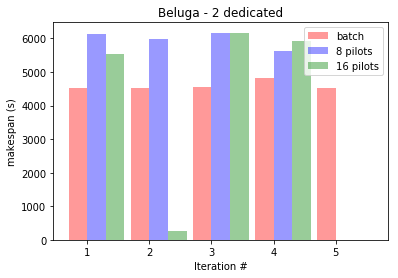

[4525.531777143478, 4513.367112874985, 4544.943446159363, 4814.9512774944305, 4513.529195547104]


In [7]:
## 2 dedicated
individual_charts(dedicated_2, 2)
print(dedicated_2['batch'])

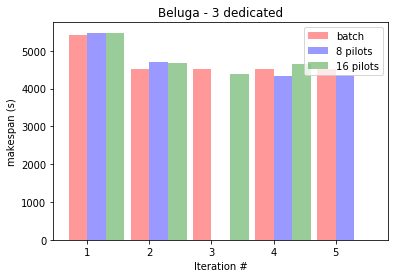

In [8]:
## 3 dedicated
individual_charts(dedicated_3, 3)

## FIGURE 1 - Makespan difference

In [9]:
def get_dedicated_data(dedicated_dict, num_pilot):
    batch = dedicated_dict['batch']
    pilot = dedicated_dict['{}pilots'.format(num_pilot)]
    data = [batch[i] - pilot[i] for i in range(len(batch)) if batch[i] != 0 and pilot[i] != 0]
    return data
    
def makespan_box(dedicated_1, dedicate_2, dedicated_3, num_pilot):
    fig, ax = plt.subplots()
    data = [get_dedicated_data(dedicated_1, num_pilot),
            get_dedicated_data(dedicated_2, num_pilot),
            get_dedicated_data(dedicated_3, num_pilot)]
    pos = np.array(range(len(data))) + 1
    bp = ax.boxplot(data, sym='k+', positions=pos)
    
    ax.set_xlabel('# dedicated')
    ax.set_ylabel('makespan')
    ax.set_title('Beluga - {} pilots'.format(num_pilot))
    plt.setp(bp['whiskers'], color='k', linestyle='-')
    plt.setp(bp['fliers'], markersize=3.0)
    plt.show()
    

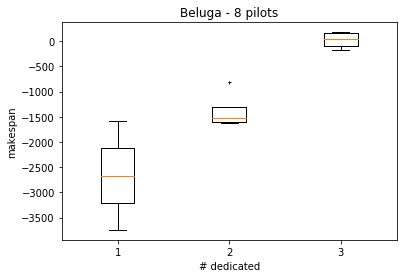

In [10]:
makespan_box(dedicated_1, dedicated_2, dedicated_3, 8)

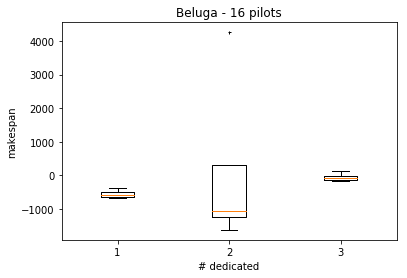

In [11]:
makespan_box(dedicated_1, dedicated_2, dedicated_3, 16)

## Figure 2 - Queuing time difference

In [12]:
def queuing_time(batch_data, pilot_data):
    return [batch_data[i]['sid'][0]['start_time'] - min([p['start_time'] for p in pilot_data[i]['sid']])
            for i in range(len(batch_data))
            if batch_data[i]['success'] and pilot_data[i]['success']]

def makespan_all(batch_data, pilot_data):
    return [(batch_data[i]['end_time'] - batch_data[i]['start_time']) - 
            (pilot_data[i]['end_time'] - pilot_data[i]['start_time'])
            for i in range(len(batch_data))
            if batch_data[i]['success'] and pilot_data[i]['success']]
    
def makespan_queue(num_pilot):
    pilot_data = None
    if num_pilot == 8:
        pilot_data = pilots8
    else:
        pilot_data = pilots16
    return (queuing_time(batch, pilot_data), makespan_all(batch, pilot_data))

def queue_scatter(queue, ms, num_pilot, system="Beluga"):
    fig, ax = plt.subplots()
    ax.scatter(queue, ms, alpha=0.5)
    
    b, m = np.polynomial.polynomial.polyfit(queue, ms, 1)
    ax.plot(np.asarray(queue), b + m * np.asarray(queue), '-')
    ax.set_xlabel('Queuing time difference of first pilot')
    ax.set_ylabel('Makespan difference')
    ax.set_title('{0} - {1} pilots'.format(system, num_pilot))
    plt.show()
    
    print('Regression line: {0}x + {1}'.format(m, b))

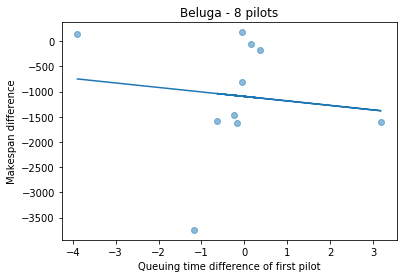

Regression line: -89.1266213746158x + -1095.9846451848705


In [13]:
# Beluga 8 pilots
queue_scatter(*makespan_queue(8), num_pilot=8)


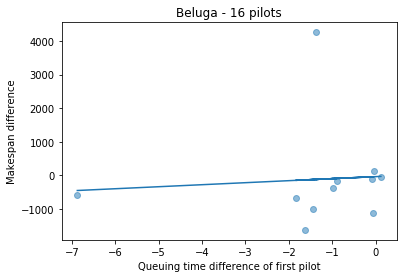

Regression line: 59.993410624218626x + -37.891092916854966


In [14]:
#Beluga 16 pilots
queue_scatter(*makespan_queue(16), num_pilot=16)

## Figure 3A - Average number of nodes

In [15]:
from math import floor

def get_pilot_info(job, t):
    if job['end_time'] is None:
        return []
    makespan_dict = {}
    
    makespan_dict[job['start_time']] = []
    makespan_dict[job['end_time']] = []
    # First passage
    for sid in job['sid']:
        if sid['start_time'] not in makespan_dict:
            makespan_dict[sid['start_time']] = [sid[t][0] if t == 'nodes' else sid[t]]
        else:
            makespan_dict[sid['start_time']].extend(sid[t] if t == 'nodes' else [sid[t]])
           
        if sid['end_time'] is None:
            sid['end_time'] = job['end_time']
        if sid['end_time'] not in makespan_dict:
            makespan_dict[sid['end_time']] = [sid[t][0] if t == 'nodes' else sid[t]]
        else:
            makespan_dict[sid['end_time']].extend(sid[t] if t == 'nodes' else [sid[t]])
    # Second passage
    for sid in job['sid']:
        for k,v in makespan_dict.items():
            if k > sid['start_time'] and k < sid['end_time']:
                v.extend(sid['nodes'])
    
    return [(k, len(set(v))) for k, v in sorted(makespan_dict.items())]

pilot_avgtype = lambda x: sum([(x[i][1]*(x[i+1][0] - x[i][0])) 
                                for i in range(1, len(x) - 1)])/(x[-1][0] - x[0][0])
get_pilot_avgnodes = lambda x,y: ((pilot_avgtype(get_pilot_info(x, 'nodes'))),
                                  (y['end_time'] - y['start_time']) - (x['end_time'] - x['start_time']),
                                   x['end_time'] - x['start_time'])


get_batch_avgnodes = lambda x:(((len(set(x['sid'][0]['nodes'])) *
                                  (x['sid'][0]['end_time'] - x['sid'][0]['start_time'])) /
                              (x['end_time'] - x['start_time'])), x['end_time'] - x['start_time'])



In [16]:
avgn_8pilots = [get_pilot_avgnodes(job, batch[idx])
               for idx, job in enumerate(pilots8)
               if job['success'] and job['end_time'] is not None and batch[idx]['success']]
avgn_16pilots = [get_pilot_avgnodes(job, batch[idx])
                for idx, job in enumerate(pilots16)
                if job['success'] and job['end_time'] is not None and batch[idx]['success']]
avgn_batch = [get_batch_avgnodes(job) for job in batch if job['success'] and job['end_time'] is not None]

In [17]:
def avg_scatter(data, num_pilot, type='node', system="Beluga"):
    fig, ax = plt.subplots()
    avg_els = [i[0] for i in data]
    makespan_diff = [i[1] for i in data]
    ax.scatter(avg_els, makespan_diff, alpha=0.5)
    
    b, m = np.polynomial.polynomial.polyfit(avg_els, makespan_diff, 1)
    ax.plot(np.asarray(avg_els), b + m * np.asarray(avg_els), '-')
    ax.set_xlabel('Average number of {}'.format(type))
    ax.set_ylabel('Makespan difference')
    ax.set_title('{0} - {1} pilots'.format(system, num_pilot))
    plt.show()
    
    print('Regression line: {0}x + {1}'.format(m, b))

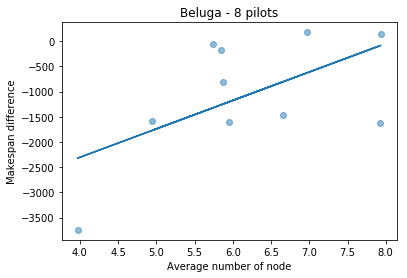

Regression line: 564.2128981021365x + -4561.191478677914


In [18]:
# 8 pilots
avg_scatter(avgn_8pilots, 8)

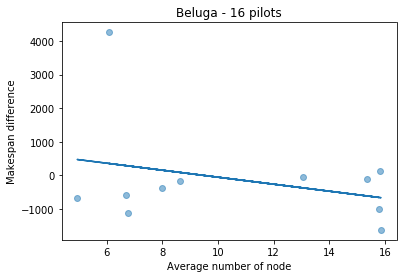

Regression line: -104.17967089836539x + 987.1636549898989


In [19]:
# 16 pilots
avg_scatter(avgn_16pilots, 16)

## Figure 3B - Average number of pilots

In [20]:
get_avgpilots = lambda x,y: ((pilot_avgtype(get_pilot_info(x, 'id'))),
                                  (y['end_time'] - y['start_time']) - (x['end_time'] - x['start_time']))
avgp_8pilots = [get_avgpilots(job, batch[idx])
               for idx, job in enumerate(pilots8)
               if job['success'] and job['end_time'] is not None and batch[idx]['success']]
avgp_16pilots = [get_avgpilots(job, batch[idx])
                for idx, job in enumerate(pilots16)
                if job['success'] and job['end_time'] is not None and batch[idx]['success']]


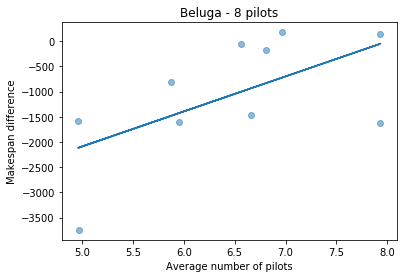

Regression line: 694.3489142984254x + -5559.225015672885


In [21]:
# 8 pilots
avg_scatter(avgp_8pilots, 8, 'pilots')

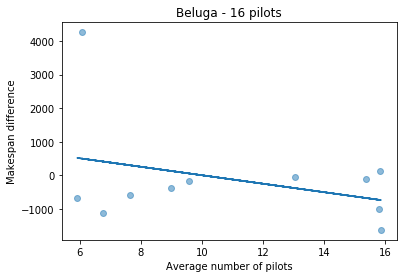

Regression line: -126.2984022497902x + 1266.894011535033


In [22]:
avg_scatter(avgp_16pilots, 16, 'pilots')

In [23]:
num_cpus = { '1d': [16, 2, 1], '2d': [16, 4, 2], '3d': [16, 6, 4]}

def get_ncpus(name):
    if 'single' in name:
        return 16
    elif '8n1d' in name:
        return 2
    elif '16n1d' in name:
        return 1
    elif 'double' in name:
        return 32
    elif '8n2d' in name:
        return 4
    elif '16n2d' in name:
        return 2
    elif 'triple' in name:
        return 48
    elif '8n3d' in name:
        return 6
    elif '16n3d':
        return 4

get_pilot_avgpilots = lambda x,y: ((pilot_avgtype(get_pilot_info(x, 'id'))),
                                  (y['end_time'] - y['start_time']) - (x['end_time'] - x['start_time']),
                                   x['end_time'] - x['start_time'])


get_batch_avgpilots = lambda x:(((len(set(x['sid'][0]['nodes'])) *
                                  (x['sid'][0]['end_time'] - x['sid'][0]['start_time'])) /
                              (x['end_time'] - x['start_time'])), x['end_time'] - x['start_time'])

batch_pilots8 = list(zip(batch, pilots8))
m1_m2_b8 = [(el[0]['end_time'] - el[0]['start_time']) / (el[1]['end_time'] - el[1]['start_time'])
            for el in batch_pilots8 if el[0]['success'] and el[1]['success']]

w1_w2_b8 = [(get_pilot_avgpilots(el[1], el[0])[0] * get_ncpus(el[1]['name'])) / 
            (get_batch_avgpilots(el[0])[0] * get_ncpus(el[0]['name']))
            for el in batch_pilots8 if el[0]['success'] and el[1]['success']]

batch_pilots16 = list(zip(batch, pilots16))
m1_m2_b16 = [(el[0]['end_time'] - el[0]['start_time']) / (el[1]['end_time'] - el[1]['start_time'])
            for el in batch_pilots16 if el[0]['success'] and el[1]['success']]

w1_w2_b16 = [(get_pilot_avgpilots(el[1], el[0])[0] * get_ncpus(el[1]['name']) / 
              (get_batch_avgpilots(el[0])[0] * get_ncpus(el[0]['name'])))
            for el in batch_pilots16 if el[0]['success'] and el[1]['success']]




In [24]:
def basic_model(w1w2, m1m2, num_pilot, system="Beluga"):
    fig, ax = plt.subplots()

    ax.scatter(w1w2, m1m2, alpha=0.5)
    
    b, m = np.polynomial.polynomial.polyfit(w1w2, m1m2, 1)
    ax.plot(np.asarray(w1w2), b + m * np.asarray(w1w2), '-')
    ax.set_xlabel('W2 - pilot / W1 - batch')
    ax.set_ylabel('M1 - batch / M2 - pilot')
    ax.set_title('{0} - {1} pilots'.format(system, num_pilot))
    plt.show()
    
    print('Regression line: {0}x + {1}'.format(m, b))

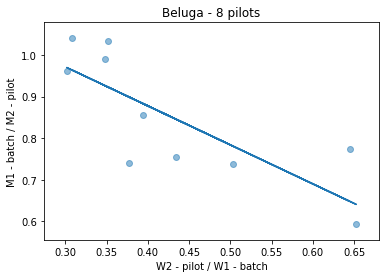

Regression line: -0.9378940545963392x + 1.2526820122736397


In [25]:
# 8 pilots
basic_model(w1_w2_b8, m1_m2_b8, 8)

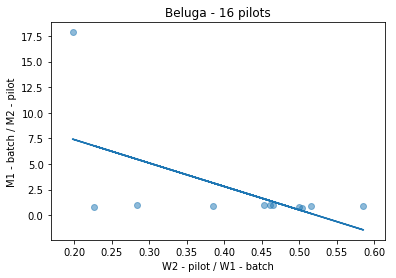

Regression line: -22.85788219401026x + 11.958248649900948


In [26]:
basic_model(w1_w2_b16, m1_m2_b16, 16)

In [27]:
m1_m2_batch = [el['end_time'] - el['start_time']
            for el in batch if el['success']]

w1_w2_batch = [(get_batch_avgpilots(el)[0] * get_ncpus(el['name']))
            for el in batch if el['success']]


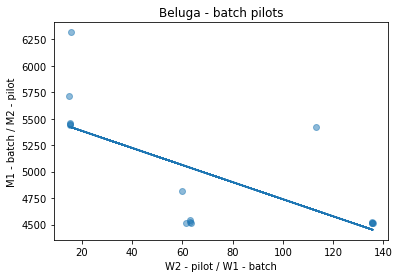

Regression line: -8.08122051257906x + 5546.90171722116


In [28]:
basic_model(w1_w2_batch, m1_m2_batch, "batch")

In [29]:
m1_m2_8p = [(el['end_time'] - el['start_time'])
            for el in pilots8 if el['success']]

w1_w2_8p = [(get_pilot_avgpilots(el, el)[0] * get_ncpus(el['name']))
            for el in pilots8 if el['success']]


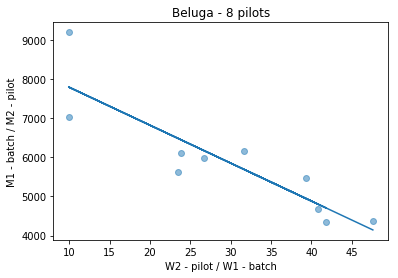

Regression line: -96.97011956287112x + 8761.735861331857


In [30]:
basic_model(w1_w2_8p, m1_m2_8p, "8")

In [31]:
m1_m2_16p = [(el['end_time'] - el['start_time'])
            for idx, el in enumerate(pilots16) if el['success']]
w1_w2_16p = [(get_pilot_avgpilots(el, el)[0] * get_ncpus(el['name']))
            for el in pilots16 if el['success']]


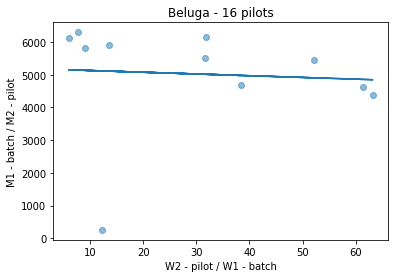

Regression line: -5.290201828858345x + 5184.211181379109


In [32]:
basic_model(w1_w2_16p, m1_m2_16p, "16")

In [33]:
dedicated_2['batch']

[4525.531777143478,
 4513.367112874985,
 4544.943446159363,
 4814.9512774944305,
 4513.529195547104]

In [34]:
batch

[{'name': 'batch_triple',
  'timestamp': '2019-04-21T08:52:37.936818',
  'start_time': 1555861957.9368308,
  'end_time': 1555867377.8542314,
  'success': True,
  'sid': [{'id': 19857272,
    'start_time': 1555862817.194185,
    'end_time': 1555867079.5770464,
    'nodes': ['172.16.139.74', '172.16.139.27', '172.16.136.232'],
    'succeeded': True}]},
 {'name': 'batch_single',
  'timestamp': '2019-04-21T10:24:07.297876',
  'start_time': 1555867447.2978976,
  'end_time': 1555872887.3302581,
  'success': True,
  'sid': [{'id': 19882271,
    'start_time': 1555867451.9000285,
    'end_time': 1555872681.5840037,
    'nodes': ['172.16.138.171'],
    'succeeded': True}]},
 {'name': 'batch_double',
  'timestamp': '2019-04-21T12:21:31.057436',
  'start_time': 1555874491.0574486,
  'end_time': 1555879016.5892258,
  'success': True,
  'sid': [{'id': 19885330,
    'start_time': 1555874498.514392,
    'end_time': 1555878957.2253723,
    'nodes': ['172.16.137.147', '172.16.137.139'],
    'succeeded':

In [35]:
1555391162.1983469- 1555387449.3197367

3712.8786101341248

In [36]:
dedicated_2["16pilots"]

[5524.226067304611,
 252.88978695869446,
 6168.7371072769165,
 5923.388880968094,
 0]

In [37]:
[el for el in pilots16 if el['id'] == '16p2d']

KeyError: 'id'